In [1]:
import os
import numpy as np
import pandas as pd
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from transformers import AutoTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix , accuracy_score , classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
import platform
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.layers import Dense, Embedding, Conv1D, LSTM, Reshape, AveragePooling1D, GlobalMaxPooling1D, Input, MaxPooling1D, Dropout, Flatten,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from keras import regularizers
seed=2023

In [2]:
print(platform.python_version())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.9.12
Num GPUs Available:  1


In [3]:
df0 = pd.read_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_dataAll_filtered_NameShorted.csv")
df0

,subject_id,hadm_id,chartdate,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,...,age,resprate,acuity,Chief Complaint,icd_title,History of Present Illness,Past Medical History,Allergies,Family History,hospital_expire_flag
0,10001217,24597018,2157/11/19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55,16.0,3.0,"LEFT HAND PAINS, Left hand and face numbness, ...",Cerebral edema; Compression of brain; Family h...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,Penicillins,"Mother with pancreatic cancer, brother-lung ca...",0
1,10003019,21616816,2174/9/18,2.6,NaN,10.4,102.0,NaN,2.8,32.0,...,72,16.0,2.0,"FEVER/MS CHANGES, confusion, rehab placement","Acute kidney failure, unspecified; Asthma, uns...","___ male w/ PMH of sarcoidosis, sleep apnea, n...","1. Sarcoidosis, dx skin bx:intestinal & pulmon...",Oxycodone / Ragweed,"Mother:___, cardiac disease. Father:diverticul...",0
2,10005808,26543907,2119/1/2,NaN,48.0,9.3,105.0,NaN,2.5,18.0,...,53,NaN,NaN,limb weakness and tingling,Acute infective polyneuritis,Mr. ___ is a ___ year old right handed gentlem...,Hiatal hernia in ___ Occasional heartburn,No Known Allergies / Adverse Drug Reactions,He has no family history of autoimmune disease...,0
3,10006269,27357430,2124/6/26,4.9,80.0,NaN,95.0,NaN,NaN,15.0,...,51,19.0,3.0,"Fever, Headache",Duodenitis without bleeding; Essential (primar...,NaN,NaN,No Known Allergies / Adverse Drug Reactions,NaN,0
4,10014078,25809882,2166/8/22,NaN,NaN,8.1,117.0,NaN,2.8,7.0,...,60,NaN,NaN,seizure,Benign neoplasm of cerebral meninges; Diabetes...,The pt is a ___ year-old woman who presents as...,hx of atypical meningioma - grade 2 - resected...,No Known Allergies / Adverse Drug Reactions,noncontributory,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790,19994772,29219051,2181/4/18,NaN,NaN,NaN,103.0,150.0,NaN,9.0,...,55,20.0,2.0,Aletered mental status and fever,Abnormal involuntary movements; Candidiasis of...,___ is a ___ woman with,PAST MEDICAL HISTORY:Recurrent glioblastoma in...,Keflex,Non-contributory.,0
5791,19994772,29606061,2180/12/18,NaN,NaN,9.7,103.0,NaN,3.3,16.0,...,54,NaN,NaN,Recurrent glioblastoma.,"Cerebral aneurysm, nonruptured; Compression of...",Ms. ___ is a ___ y/o F s/p resection of gliobl...,Hyperlipidemia,___,non-contributory,0
5792,19995080,23057109,2147/7/13,2.3,961.0,7.5,105.0,NaN,2.3,17.0,...,59,NaN,NaN,Confusion- Altered Mental Status- transfer fro...,Calculus of gallbladder and bile duct without ...,___ M with AIDS and med non-compliance (CD4 20...,"- AIDS off ART prescribed for Truvada T qd, Ka...",Penicillins,Father died of AD at age ___. Mother died of D...,0
5793,19999784,24935234,2119/7/7,4.3,NaN,NaN,NaN,102.0,NaN,NaN,...,57,16.0,2.0,"Abnormal MRI, weakness",Abnormal cytological findings in cerebrospinal...,Mr. ___ is a ___ without significant medical h...,PAST ONCOLOGIC HISTORY:___ is a ___ right-hand...,No Known Allergies / Adverse Drug Reactions,Father had prostate cancer. Denies otherwise ...,0


In [4]:
df0.hospital_expire_flag.value_counts()

0    5500
1     295
Name: hospital_expire_flag, dtype: int64

In [5]:
# loading structured data
df3 = df0.iloc[:,3:-7]
df3['hospital_expire_flag'] = df0['hospital_expire_flag']
df_train, df_test = train_test_split(df3, test_size=0.2, random_state = seed, stratify=df3['hospital_expire_flag'])
df_train

,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,B_Eosinophils,B_INR(PT),B_MCV,...,B_WhiteBloodCells,C_LactateDehydrogenase,C_Protein,C_Eosinophils,C_Polys,C_RBC,age,resprate,acuity,hospital_expire_flag
918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.0,65.0,NaN,0.0,0.0,54,18.0,2.0,0
1754,3.8,88.0,8.6,107.0,282.0,2.3,6.0,NaN,1.0,89.0,...,16.2,NaN,40.0,NaN,47.0,725.0,54,12.0,2.0,0
3831,NaN,NaN,9.3,95.0,NaN,3.2,14.0,NaN,1.1,80.0,...,3.6,NaN,37.0,NaN,60.0,6800.0,74,NaN,NaN,0
3261,2.7,NaN,7.9,104.0,511.0,3.0,14.0,NaN,1.1,85.0,...,10.3,NaN,43.0,1.0,94.0,1220.0,40,NaN,NaN,0
1543,3.5,147.0,NaN,104.0,NaN,NaN,9.0,1.0,1.0,91.0,...,2.6,NaN,29.0,NaN,0.0,106.0,47,18.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,2.1,60.0,8.2,108.0,224.0,3.6,8.0,NaN,1.3,92.0,...,6.0,NaN,27.0,NaN,0.0,3.0,62,NaN,NaN,0
3700,3.8,74.0,8.9,106.0,NaN,3.9,14.0,0.1,1.5,96.0,...,13.8,NaN,51.0,NaN,38.0,469.0,68,26.0,2.0,0
2647,NaN,NaN,9.0,109.0,NaN,2.3,8.0,1.0,NaN,90.0,...,58.2,NaN,44.0,NaN,24.0,160.0,61,18.0,1.0,0
4068,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.6,1.1,90.0,...,3.9,NaN,22.0,NaN,0.0,1.0,64,20.0,3.0,0


In [6]:
from sklearn.impute import KNNImputer
import pickle

cols = df_train.columns.tolist()
index_train = df_train.index.tolist()
index_test = df_test.index.tolist()

imputer = KNNImputer(n_neighbors=5, weights='distance')
df_train = imputer.fit_transform(df_train)
df_test = imputer.transform(df_test)

df_train = pd.DataFrame(df_train, columns=cols, index=index_train)
df_test = pd.DataFrame(df_test, columns=cols, index=index_test)

df_train

,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,B_Eosinophils,B_INR(PT),B_MCV,...,B_WhiteBloodCells,C_LactateDehydrogenase,C_Protein,C_Eosinophils,C_Polys,C_RBC,age,resprate,acuity,hospital_expire_flag
918,4.078562,73.930420,8.750000,104.000000,325.920835,4.150000,19.5,4.755480,1.250000,87.0,...,8.45,15.000000,65.0,2.191438,0.0,0.0,54.0,18.000000,2.000000,0.0
1754,3.800000,88.000000,8.600000,107.000000,282.000000,2.300000,6.0,1.580664,1.000000,89.0,...,16.20,56.984542,40.0,1.479802,47.0,725.0,54.0,12.000000,2.000000,0.0
3831,3.572786,77.141034,9.300000,95.000000,307.457595,3.200000,14.0,1.817352,1.100000,80.0,...,3.60,67.217247,37.0,2.311837,60.0,6800.0,74.0,21.030636,1.624593,0.0
3261,2.700000,79.399933,7.900000,104.000000,511.000000,3.000000,14.0,0.513097,1.100000,85.0,...,10.30,89.753259,43.0,1.000000,94.0,1220.0,40.0,18.512419,2.097177,0.0
1543,3.500000,147.000000,8.762034,104.000000,250.904261,3.264256,9.0,1.000000,1.000000,91.0,...,2.60,24.303428,29.0,3.437696,0.0,106.0,47.0,18.000000,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,2.100000,60.000000,8.200000,108.000000,224.000000,3.600000,8.0,2.499692,1.300000,92.0,...,6.00,20.180941,27.0,1.720484,0.0,3.0,62.0,18.317974,2.004036,0.0
3700,3.800000,74.000000,8.900000,106.000000,331.312008,3.900000,14.0,0.100000,1.500000,96.0,...,13.80,59.062401,51.0,1.368608,38.0,469.0,68.0,26.000000,2.000000,0.0
2647,3.946738,98.656034,9.000000,109.000000,319.892397,2.300000,8.0,1.000000,1.201393,90.0,...,58.20,24.141283,44.0,2.910087,24.0,160.0,61.0,18.000000,1.000000,0.0
4068,3.934594,74.259295,9.845201,101.412672,183.226227,4.197642,20.0,1.600000,1.100000,90.0,...,3.90,16.793837,22.0,6.664316,0.0,1.0,64.0,20.000000,3.000000,0.0


In [7]:
# generate X subsets for Modelling 
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
print(X_train.shape, X_test.shape)

(4636, 23) (1159, 23)


In [8]:
# generate Y subsets for Modelling 
y_train = df_train.iloc[:,-1:]
y_test = df_test.iloc[:,-1:]
y_train.shape, y_test.shape

((4636, 1), (1159, 1))

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
X_train[:2]

(4636, 23) (1159, 23)


array([[ 0.76458032, -0.39503373, -0.12220844,  0.12619625,  0.17457904,
         0.77769269,  0.10297477,  1.10331995,  0.52618666, -0.5387392 ,
         2.02674657,  0.74298978,  0.75668158, -0.68278577, -0.11388473,
        -0.53494472, -0.06655984, -0.15601875, -0.57228933, -0.13220108,
        -0.07227331,  0.07689207, -0.32158894],
       [ 0.16690243, -0.15824737, -0.35033128,  0.73106561,  0.01081673,
        -1.36208259, -0.88162571, -0.14428555, -0.94581997, -0.23127834,
         0.84413649, -0.90286498,  0.44849945,  0.14154302,  1.09537036,
         0.38209825, -0.16252979, -0.39213147,  1.29713182, -0.10577416,
        -0.07227331, -2.85363278, -0.32158894]])

In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train['hospital_expire_flag'].values), y=y_train['hospital_expire_flag'].values)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5268181818181819, 1: 9.822033898305085}

# Training

In [11]:
# CNN
# K-fold verification
# develip Neural Network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten,AveragePooling1D, MaxPooling1D
n_cols = X_train.shape[1]
# kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)
def build_model():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(n_cols, 1)))
    model.add(MaxPooling1D(pool_size=3))
#     model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
#     model.add(AveragePooling1D(pool_size=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    # model.summary()
    model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [62]:
num_epochs = 100
k = 4
num_val_samples = X_train.shape[0] // k
all_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = y_train[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([X_train[:i * num_val_samples], X_train[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i+1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                       epochs = num_epochs, batch_size = 64, verbose = 0, class_weight=class_weights)
    all_histories.append(history.history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [63]:
average_loss = [np.mean([x['loss'][i] for x in all_histories]) for i in range(num_epochs)]
average_accuracy = [np.mean([x['accuracy'][i] for x in all_histories]) for i in range(num_epochs)]

average_val_loss = [np.mean([x['val_loss'][i] for x in all_histories]) for i in range(num_epochs)]
average_val_accuracy = [np.mean([x['val_accuracy'][i] for x in all_histories]) for i in range(num_epochs)]

In [64]:
gap = 1
n = int(num_epochs/gap)

loss_gap10 = [np.average(average_loss[gap*i:gap*(i+1)]) for i in range(n)]
acc_gap10 = [np.average(average_accuracy[gap*i:gap*(i+1)]) for i in range(n)]

val_loss_gap10 = [np.average(average_val_loss[gap*i:gap*(i+1)]) for i in range(n)]
val_acc_gap10 = [np.average(average_val_accuracy[gap*i:gap*(i+1)]) for i in range(n)]

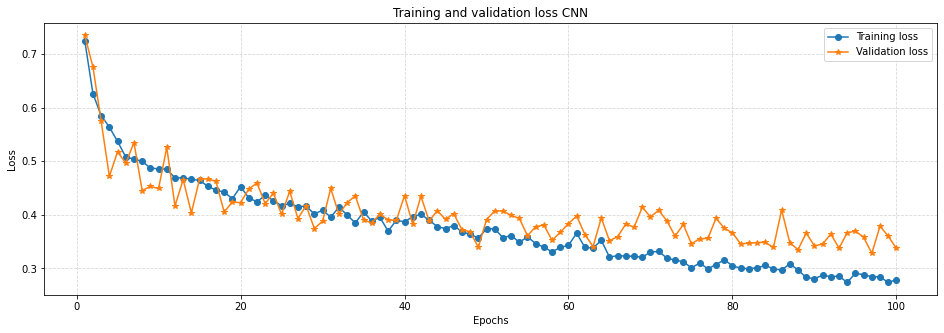

In [65]:
epochs = [each*gap for each in range(1, 1+n)]

plt.figure(figsize = (16,5))
plt.clf() 
plt.plot(epochs, loss_gap10, 'o-', label='Training loss')
plt.plot(epochs, val_loss_gap10, '*-', label='Validation loss')
plt.title('Training and validation loss CNN')
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./image/CNN_loss_standardization.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

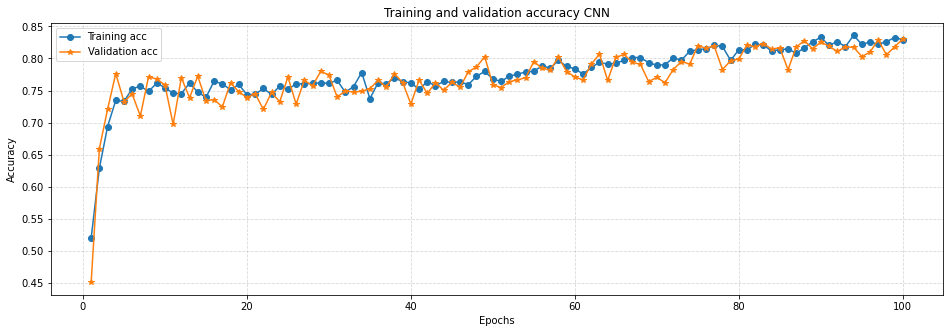

In [67]:
plt.figure(figsize = (16,5))
# plt.grid(axis="y")
plt.plot(epochs, acc_gap10, 'o-', label='Training acc')
plt.plot(epochs, val_acc_gap10, '*-', label='Validation acc')
plt.title('Training and validation accuracy CNN')
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plt.savefig('./image/CNN_accuracy_standardization.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

In [166]:
model = build_model()
model.fit(X_train, y_train, epochs = 2, batch_size = 64, verbose = 1, class_weight=class_weights)

Epoch 1/2
73/73 [==============================] - 1s 8ms/step - loss: 0.7118 - accuracy: 0.6400
Epoch 2/2
73/73 [==============================] - 0s 6ms/step - loss: 0.6046 - accuracy: 0.6821


In [167]:
# save model
# model.save()

In [11]:
# load model
from tensorflow.keras.models import load_model
model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.1/aim2_selected/Aim2_Structured_CNN.h5')

# Testing

In [12]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 2s 2ms/step - loss: 0.5564 - accuracy: 0.7455


[0.5564424395561218, 0.7454702258110046]

In [13]:
score,acc = model.evaluate(X_test, y_test, verbose = 2)
print("score: %.3f" % (score))
print("acc: %.3f" % (acc))

37/37 - 0s - loss: 0.5564 - accuracy: 0.7455 - 79ms/epoch - 2ms/step
score: 0.556
acc: 0.745


In [14]:
y_predict = model.predict(X_test)
y_predict

37/37 [==============================] - 0s 1ms/step


array([[0.8078943 , 0.19210573],
       [0.69448435, 0.30551562],
       [0.7889692 , 0.21103077],
       ...,
       [0.40125743, 0.5987426 ],
       [0.28956175, 0.71043825],
       [0.3501585 , 0.6498415 ]], dtype=float32)

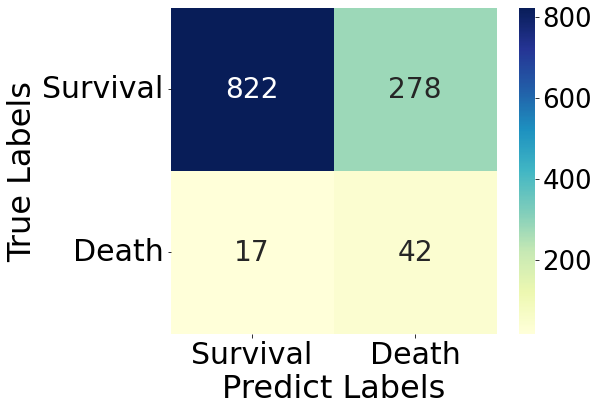

In [15]:
# generate confusion matrix
labels1 = ["Survival", "Death"]
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test, np.argmax(y_predict,axis=1))
ax = sns.heatmap(cm, square=True, annot=True , cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".0f")   #square=True, annot=True showing number
# plt.matshow(cm)
# plt.title('Confusion matrix DNN', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.colorbar()
plt.xticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)

plt.show()

In [16]:
cm

array([[822, 278],
       [ 17,  42]], dtype=int64)

In [17]:
predict_matrix = np.zeros(cm.shape)
for i in range(cm.shape[0]):
    temp = np.sum(cm[i])
    for j in range(cm.shape[1]):
        predict_matrix[i,j] = cm[i,j]/temp

In [18]:
predict_matrix

array([[0.74727273, 0.25272727],
       [0.28813559, 0.71186441]])

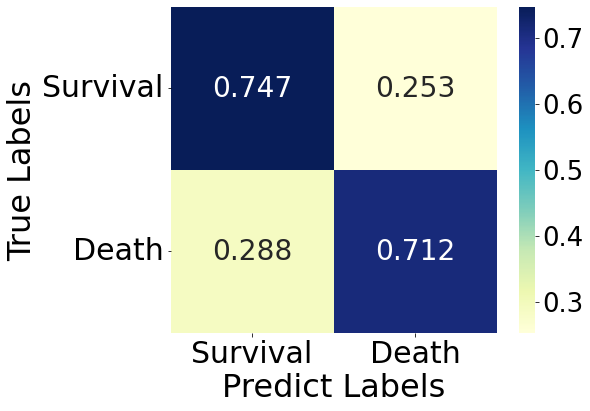

In [19]:
plt.figure(figsize = (8, 6))
ax = sns.heatmap(predict_matrix, square=True, annot=True ,cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".3f")
plt.xticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.title('Confusion matrix of prediction', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

plt.show()

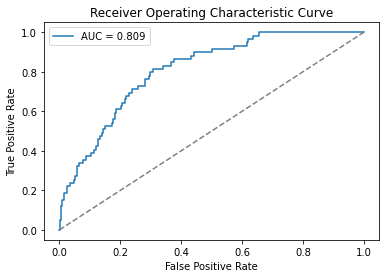

In [20]:
# Calculate AUC score and plot ROC curve
auc = roc_auc_score(y_test, y_predict[:,1])
fpr, tpr, thresholds = roc_curve(y_test, y_predict[:,1])

plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [21]:
# CNN stru
y_test_all_nn2 = y_test.copy()
y_predict_all_nn2 = y_predict.copy()

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/CNN_stru.pickle","wb") as f:
    pickle.dump([y_test_all_nn2,y_predict_all_nn2], f)

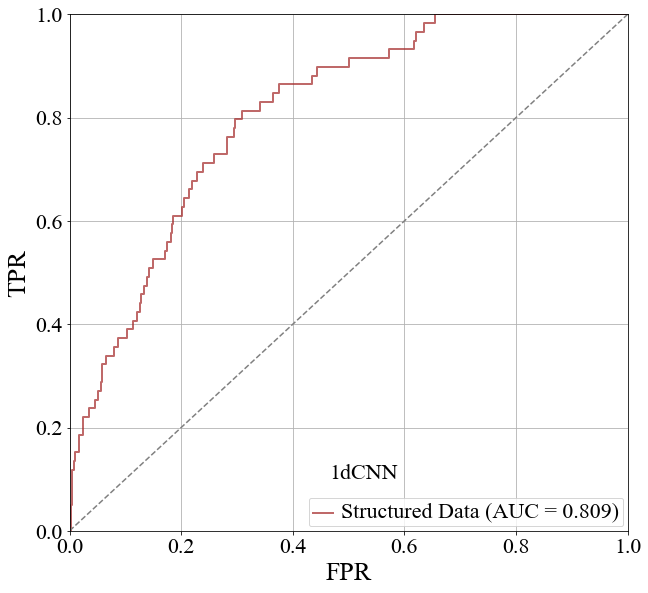

In [22]:
fpr_3final, tpr_3final, _ = roc_curve(y_test, y_predict[:,1])
auc_3final = roc_auc_score(y_test, y_predict[:,1])

plt.figure(figsize=(10, 9.5))

plt.plot(fpr_3final, tpr_3final, color='brown', label=f'Structured Data (AUC = {auc_3final:.3f})', linewidth=2, alpha=0.7)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('FPR', fontsize=26, fontname='Times New Roman')  # False Positive Rate
plt.ylabel('TPR', fontsize=26, fontname='Times New Roman')    # True Positive Rate
# plt.title('ROC Curve of 8 Models', fontsize=30, fontname='Times New Roman')

legend = plt.legend(loc='lower right')
for text in legend.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(22)

plt.text(0.465,0.1, 
         '1dCNN', fontsize=22, fontname='Times New Roman', 
         transform=plt.gca().transAxes)

plt.grid()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=22, fontname='Times New Roman')
plt.yticks(fontsize=22, fontname='Times New Roman')

path = os.path.join("E:/CNSI_project/demo_and_data_5.0/figure_in_paper/aim2", "auc_structed.tif")
plt.savefig(path, dpi=300, bbox_inches='tight')

plt.show()

In [23]:
# calculate evaluation metric using test cohort
accuracy0 = np.round(accuracy_score(y_test, 
               np.argmax(y_predict,axis=1)), decimals = 3)
print('\n1dCNN Predictive Accuracy: ',accuracy0)


1dCNN Predictive Accuracy:  0.745


In [24]:
print('\nSummary of 1dCNN Precision and Recall\n') 
print(classification_report(y_test, np.argmax(y_predict,axis=1), 
                            target_names = labels1, digits=3))


Summary of 1dCNN Precision and Recall

              precision    recall  f1-score   support

    Survival      0.980     0.747     0.848      1100
       Death      0.131     0.712     0.222        59

    accuracy                          0.745      1159
   macro avg      0.555     0.730     0.535      1159
weighted avg      0.937     0.745     0.816      1159



# AUPRC、C-index and Brier Score

FCN AUPRC: 0.204
Baseline (positive class ratio): 0.051


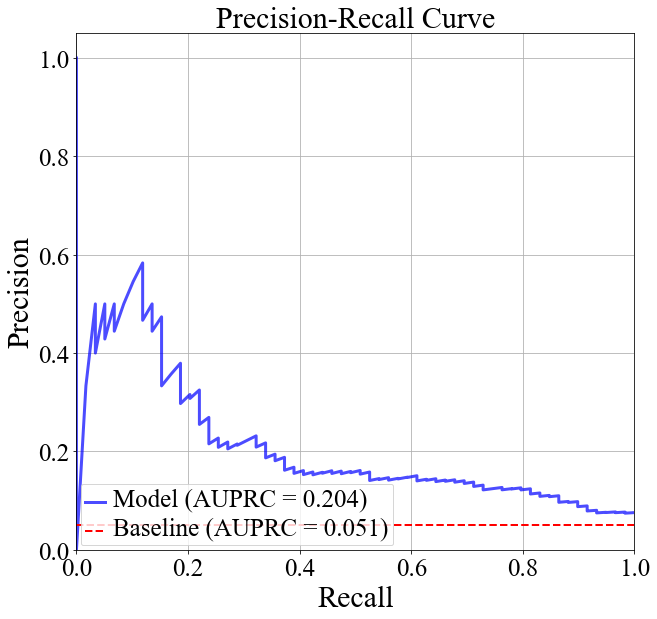

In [25]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, brier_score_loss
from lifelines.utils import concordance_index

# AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_predict[:,1])
auprc = auc(recall, precision)
print(f'FCN AUPRC: {auprc:.3f}')

baseline = np.sum(y_test.values) / y_test.shape[0]
print(f'Baseline (positive class ratio): {baseline:.3f}')

plt.figure(figsize=(10, 9.5))
plt.plot(recall, precision, color='blue', label=f'Model (AUPRC = {auprc:.3f})', linewidth=3, alpha=0.7)

plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (AUPRC = {baseline:.3f})', linewidth=2)

plt.xlabel('Recall', fontsize=30, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=30, fontname='Times New Roman')
plt.title('Precision-Recall Curve', fontsize=30, fontname='Times New Roman')

legend = plt.legend(loc='lower left')
for text in legend.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(25)

plt.grid()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=25, fontname='Times New Roman')
plt.yticks(fontsize=25, fontname='Times New Roman')

plt.show()

In [26]:
y_predict[:,1]

array([0.19210573, 0.30551562, 0.21103077, ..., 0.5987426 , 0.71043825,
       0.6498415 ], dtype=float32)

In [27]:
# C-index
c_index = concordance_index(y_test, y_predict[:,1])
print(f'FCN C-index: {c_index:.3f}')

FCN C-index: 0.809


In [28]:
# Brier Score 
brier_score = brier_score_loss(y_test, y_predict[:,1])
print(f'FCN Brier Score: {brier_score:.3f}')

FCN Brier Score: 0.183
